In [1]:
# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import interpolate

# map functions
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

# statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# scikit-learn machine learning
from sklearn.preprocessing import Normalizer, StandardScaler, normalize, scale
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, LinearRegression, SGDRegressor, RANSACRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from skopt import BayesSearchCV


# for graphing decision trees
import graphviz 
from sklearn.tree import export_graphviz

plt.style.use('seaborn-colorblind')

# special Jupyter Notebook command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 
# %matplotlib notebook

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

In [2]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', index_col=False)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 15 columns):
name           152544 non-null object
department     152544 non-null object
title          152544 non-null object
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zip            152544 non-null object
year           152544 non-null int64
dept_clean     152544 non-null object
title_clean    152544 non-null object
dtypes: float64(8), int64(1), object(6)
memory usage: 17.5+ MB


# Classification based on job titles and departments

- extract the 10 most common job titles and 10 largest departments for 2017
- run classifiers on the numeric earnings data

### 1. Generate top 10 lists

In [3]:
"""
There are more than one thousand unique job titles for less than 20,000 employees in the city of Boston earnings database. 
Any meaningful classification of job titles will need to be limited. 

Likewise, of the more than 50 departments, some have only a handful of employees. For classification purposes the dataset
will be limited to the top 10 titles and departments.
"""
# get top 10 titles by number of employees
titles_top10 = earnings\
                .groupby('title_clean')\
                .agg('size')\
                .sort_values(ascending=False)\
                .index[:10]

# get top 10 departments by number of employees

departments_top10 = earnings\
                .groupby('dept_clean')\
                .agg('size')\
                .sort_values(ascending=False)\
                .index[:10]
print(titles_top10)
print(departments_top10)

Index(['Teacher', 'Police Officer', 'Paraprofessional', 'Fire Fighter', 'Substitute Teacher', 'Lunch Hour Monitors', 'Part-Time Cafeteria Attendant', 'Cab Monitor', 'Police Detective', 'Police Sergeant'], dtype='object', name='title_clean')
Index(['Boston Public Schools', 'Boston Police Department', 'Boston Fire Department', 'Boston Cntr - Youth & Families', 'Boston Public Library', 'Public Works Department', 'Traffic Division', 'Parks Department', 'Inspectional Services Dept', 'Public Facilities Department'], dtype='object', name='dept_clean')


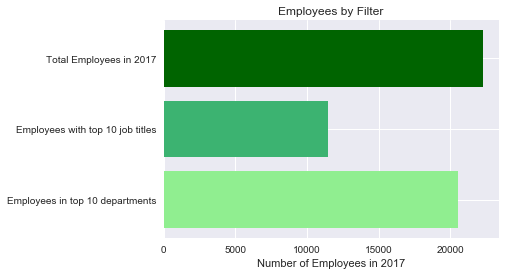

In [4]:
# top 10 titles and departments employees in 2017

# Number of employees in 2017
emp_2017 = earnings[earnings.year == 2017].shape[0]

# Employees with top 10 titles
emp_titles = earnings[earnings['title_clean'].isin(titles_top10) & (earnings.year == 2017)].shape[0]

# Employees in top 10 departments
emp_dept = earnings[earnings['dept_clean'].isin(departments_top10) & (earnings.year == 2017)].shape[0] 

data = {'Total Employees in 2017': emp_2017, 'Employees with top 10 job titles': emp_titles, 'Employees in top 10 departments': emp_dept}
category = list(data.keys())
employees = list(data.values())

plt.barh(category, employees, color=['darkgreen', 'mediumseagreen', 'lightgreen'])
plt.gca().invert_yaxis()
plt.title('Employees by Filter')
plt.xlabel('Number of Employees in 2017')
plt.show()

### 2. Cluster Analysis

Cluster analysis can help uncover hidden structures by grouping observations into clusters based on statistical similarity of features rather than relying on labeled data. In this sense, cluster analysis is unsupervised machine learning. 

This exercise will test if cluster analysis can cluster the observations by job title or department. Success would indicate that earnings structures are distinct for each job title or department, whereas failure would suggest a more egalitarian compensation.

Failure would also imply that supervised machine learning methods will be needed for classification.

The entire dataset is not well suited for label comparison due to the abundance of titles and departments. In order to simplify the analysis we'll look at the top 3 titles and departments by number of employees.

In [5]:
# limit data to top3 titles and departments

top3_titles = earnings[(earnings['title_clean'].isin(['Police Officer', 'Fire Fighter', 'Teacher'])) & 
                       (earnings['year'] == 2017)]
top3_departments = earnings[(earnings['dept_clean'].\
                             isin(['Boston Police Department', 'Boston Fire Department', 'Boston Public Schools'])) & 
                            (earnings['year'] == 2017)]

# remove non-numeric columns as well as "total":
droplist = ['name', 'department', 'title', 'total', 'zip', 'year', 'title_clean', 'dept_clean']


# by title (_t)
X_t = top3_titles.drop(droplist, axis=1)             # extract cluster data
X_t = StandardScaler().fit_transform(X_t)            # scale X
y_t, y_tl = pd.factorize(top3_titles['title_clean']) # factorize labels
X_t_labels = top3_titles['title_clean'].tolist()     # list of label strings

# by department (_d)
X_d = top3_departments.drop(droplist, axis=1)
X_d = StandardScaler().fit_transform(X_d)
y_d, y_dl = pd.factorize(top3_departments['dept_clean'])
X_d_labels = top3_departments['dept_clean'].tolist()


Scipy offers tools for hierarchical clustering which assumes no set number of clusters. The dendogram function visualizes similarity or cophentic distance between two clusters. 

In [6]:
# scipy clustering for dendrograms
mergings_t = linkage(X_t, method='average', metric='euclidean') # by title (_t)
mergings_d = linkage(X_d, method='average', metric='euclidean') # by department (_d)

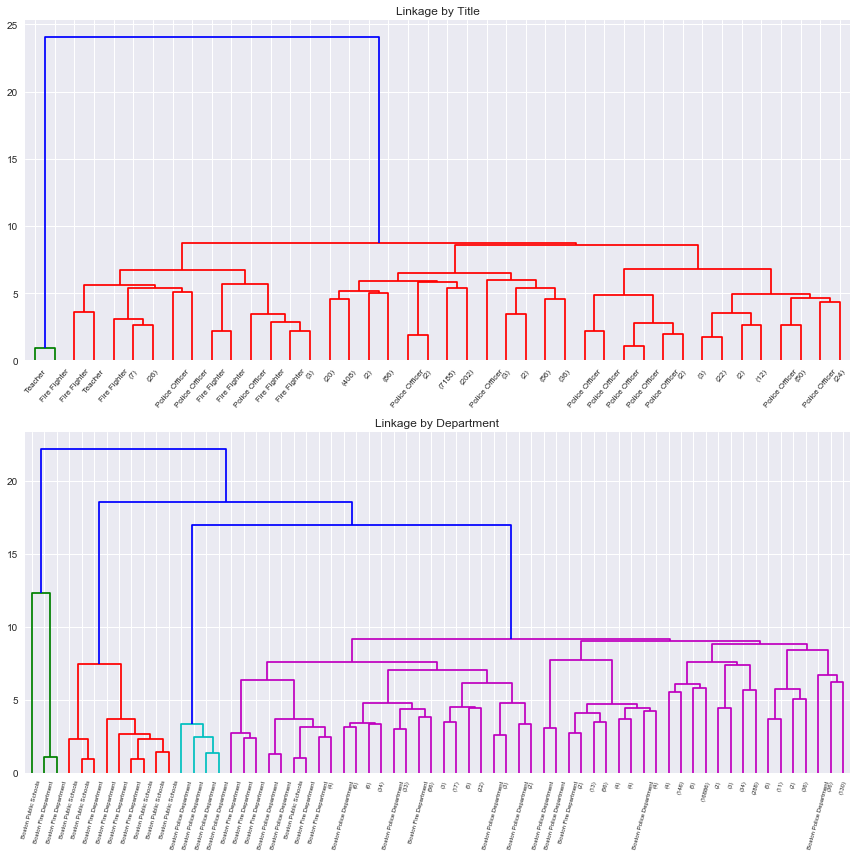

In [7]:
# dendrograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.set_title('Linkage by Title')
dendrogram(mergings_t, ax=ax1, truncate_mode='level', p=6, show_contracted=False, labels=X_t_labels, leaf_rotation=50)

ax2.set_title('Linkage by Department')
dendrogram(mergings_d, ax=ax2, truncate_mode='level', p=8, labels=X_d_labels, leaf_rotation=75)
plt.tight_layout()
plt.show()

The dendrograms for both clusterings show no clear cut-off for grouping. The labeled singleton clusters are not grouped by the label of interest and the truncated leaves imply more label ambiguity.

The next step is to predict cluster accuracy using:

***Silhouette score*** (cohesion and separation of clusters)

***Label accuracy*** (how well cluster element labels match true labels).

The following cluster algorithms will be evaluated: 

* *k*-Means
* DBSCAN
* Agglomerative Clustering

The algorithms were selected based on their potential ability to align with the number of titles or departments, i.e. result in exactly three clusters.

In [8]:
# Clustering algorithms
kmeans = KMeans(n_clusters=3)
dbscan = DBSCAN(eps=0.5, min_samples=1000)
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')

metrics_df_t = pd.DataFrame()
metrics_df_d = pd.DataFrame()
 
clustering_algorithms = (('KMeans', kmeans), ('DBSCAN', dbscan), ('Agglomerative', hc))


for name, algorithm in clustering_algorithms:
    pred = algorithm.fit_predict(X_t)
    metrics_df_t.loc[name, 'silhouette_score'] = (metrics.silhouette_score(X_t, pred)*100)
    metrics_df_t.loc[name, 'accuracy_score'] = (metrics.accuracy_score(y_t, pred)*100)
    metrics_df_t.loc[name, 'group'] = 'by_title'

for name, algorithm in clustering_algorithms:
    pred = algorithm.fit_predict(X_d)
    metrics_df_d.loc[name, 'silhouette_score'] = (metrics.silhouette_score(X_d, pred)*100)
    metrics_df_d.loc[name, 'accuracy_score'] = (metrics.accuracy_score(y_d, pred)*100)
    metrics_df_d.loc[name, 'group'] = 'by_department'


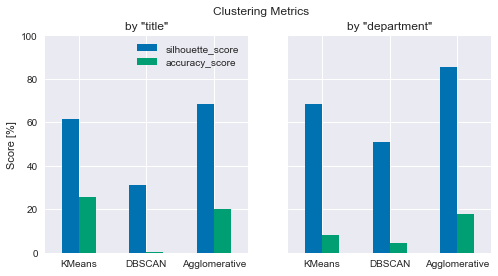

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), sharey=True)
plt.xticks(rotation=0)
metrics_df_t.plot.bar(ax=ax1)
fig.suptitle('Clustering Metrics')
ax1.set_title('by \"title\"')
ax1.set_ylabel('Score [%]')
ax1.set_ylim(0,100)
plt.xticks(rotation=0)

metrics_df_d.plot.bar(ax=ax2, legend=False)
ax2.set_title('by \"department\"')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
plt.show()

***k*-means** clustering results in meaningful structure (silhouette score), i.e. cohesion and separation, but the label accuracy is very poor. This result would be expected if the unsupervised clustering finds greater similarity across titles or departments than within. The data is clustered by earnings categories (features) rather than by title or department.

**DBSCAN** clustering is problematic in that the number of clusters is not predetermined. Instead, DBSCAN clustering determines the number of clusters by calculation based on density differences. For purposes of this analysis the number of clusters is approximately controlled by setting the minimum number of samples to 1000. The very low accuracy score indicates that either the clusters don't align with the labels or the resultant number of clusters is not equal to the number of labels (=3).

**Agglomerative Clustering** returns the best silhouette score and the highest label accuracy. The accuracy is still quite low, suggesting very little earnings bias among the 3 job titles and departments.

The agglomerative clustering results can be visualized in two or three dimensions using a PCA decomposition.

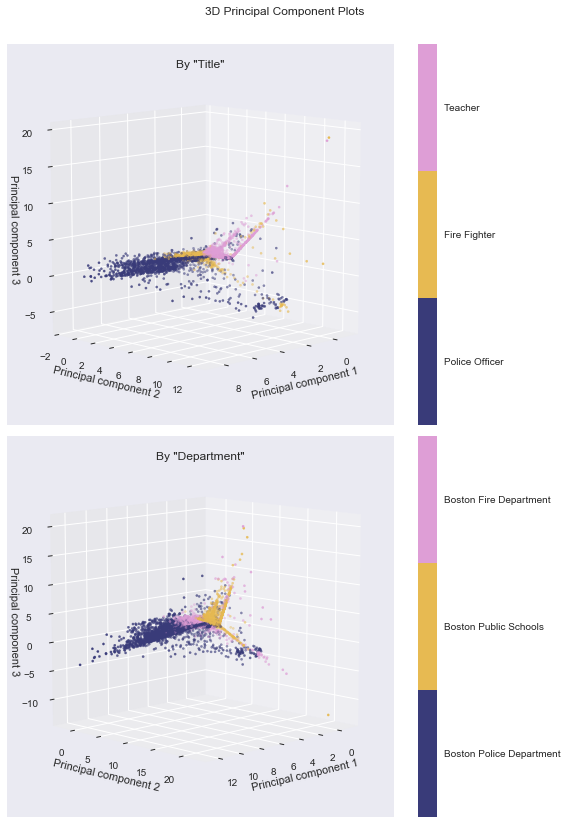

In [10]:
# three principal components

pca3d_t = PCA(n_components=3)
pca3d_d = PCA(n_components=3)

components3d_t = pca3d_t.fit_transform(X_t)
components3d_d = pca3d_d.fit_transform(X_d)

fig = plt.figure(figsize=(8,12))
fig.suptitle('3D Principal Component Plots')

ax = fig.add_subplot(211, projection='3d')

p_t = ax.scatter(components3d_t[:,0], # x
                 components3d_t[:,1], # y
                 components3d_t[:,2], # z
                 c=y_t, s=5, cmap=plt.cm.get_cmap('tab20b', 3))
ax.set_title('By \"Title\"')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')
ax.view_init(10, 45)

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: y_tl[val])
plt.colorbar(p_t, ax=ax, ticks=[0, 1, 2], format=formatter);

# Set the clim so that labels are centered on each block
p_t.set_clim(vmin=-0.5, vmax=2.5)


ax = fig.add_subplot(212, projection='3d')

p_d = ax.scatter(components3d_d[:,0], 
                 components3d_d[:,1], 
                 components3d_d[:,2], 
                 c=y_d, s=5, cmap=plt.cm.get_cmap('tab20b', 3))
ax.set_title('By \"Department\"')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')
ax.view_init(10, 45)

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: y_dl[val])
plt.colorbar(p_d, ax=ax, ticks=[0, 1, 2], format=formatter);

# Set the clim so that labels are centered on each block
p_d.set_clim(vmin=-0.5, vmax=2.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The pca plots show no obvious label oriented cluster structure when considering the title and department labels. There is also significant structure overlap which explains the label inaccuracy. Interestingly, the "Teachers" title and "Boston Public Schools" department are nearly one dimensional in the pca. This is likely due to the sparcity of data in most of the earnings features. Fire fighters and police officers have significant presence in the "**retro**", "**overtime**", "**injured**", "**detail**", and "**quinn**" categories, whereas teachers do not. 

A look at the explained variance by number of principal components suggests that the data could be reduced to two dimensions without much loss of information.

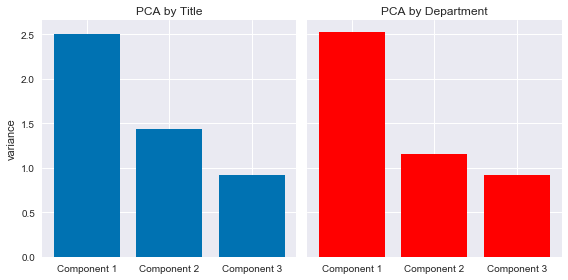

In [11]:
# plot explained variances:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), sharey=True)
features_t = range(pca3d_t.n_components_)
ax1.bar(features_t, pca3d_t.explained_variance_)
ax1.set_title('PCA by Title')
ax1.set_ylabel('variance')
ax1.set_xticks(range(3))
ax1.set_xticklabels(['Component 1', 'Component 2', 'Component 3']) 

features_d = range(pca3d_d.n_components_)
ax2.bar(features_d, pca3d_d.explained_variance_, color='r')
ax2.set_title('PCA by Department')
ax2.set_xticks(range(3))
ax2.set_xticklabels(['Component 1', 'Component 2', 'Component 3']) 

plt.tight_layout()
plt.show()

The first two components explain most of the variance, eliminating the need for higher dimensional pca plotting.

### Summary

Cluster analysis fails to find meaningful structure using three common clustering algorithms. When plotted with categorical labels, the weak cluster structure fails to conform to either *title* or *department* classification.

### 3. Classification by job title

The failure of cluster analysis to satisfactorily classify employees by either job title or department leads to the following supervised classification methods:

* ***Ridge classifier***
* ***Support vector classifier***
* ***Random forest classifier***

Supervised methods work well with multiple classes, but in order to have a minimum number of representative observations the data will be limited to the top 10 titles and departments measured by number of employees.

In [12]:
# data for classifiers:

top10_titles = earnings[(earnings['title_clean'].isin(titles_top10)) & (earnings['year'] == 2017)]

# remove non-numeric columns as well as "total" and "quinn"
X = top10_titles.drop(['name', 'department', 'title', 'total', 'zip', 'year', 'title_clean', 'dept_clean'], axis=1)
y = top10_titles['title_clean']

# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
y_test.shape[0]

3429

In [13]:
# Instantiate a RidgeClassifier:
rclf = RidgeClassifier(alpha=0.01, normalize=True)

# Fit the regressor to the data
rclf.fit(X_train, y_train)

# Compute and print the coefficients
rclf_coef = rclf.coef_

r_sq = rclf.score(X_test, y_test)
print('The ridge classifier correctly identifies {:.2f}% of the job titles.'.format(r_sq*100))

The ridge classifier correctly identifies 59.26% of the job titles.


Test set score: 0.78
Confusion Matrix:
                               0     1   2    3  4    5     6    7    8     9  count  score
Cab Monitor                    0     0  11  233  0    0     0    0   54     8    306   0.00
Fire Fighter                   0  1049   1    3  0    0    22    2    2    45   1124  93.33
Lunch Hour Monitors            0     0  10   34  0    0     0    0  314     2    360   2.78
Paraprofessional               0     1  51  996  0    0     0    0   88    79   1215  81.98
Part-Time Cafeteria Attendant  0     0  61  158  0    0     0    0   65    50    334   0.00
Police Detective               0     0   0    0  0  178   115    0    4     1    298  59.73
Police Officer                 0    11   4   90  0   27  1423    0   54     7   1616  88.06
Police Sergeant                0    12   0    0  0    7    31  241    1     7    299  80.60
Substitute Teacher             0     0  18   87  0    0     0    0  325    11    441  73.70
Teacher                        0     4  1

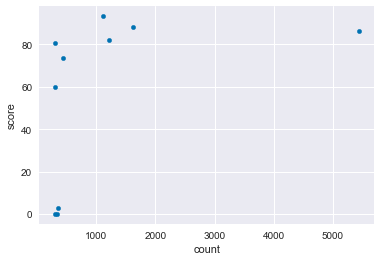

In [14]:
# support vector classifier

steps = [('scaler', StandardScaler()), ('clf', svm.SVC())]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

# metrics:
print('Test set score: {:.2f}'.format(pipeline.score(X_test, y_test)))

pred = pipeline.predict(X)
# a2 = metrics.accuracy_score(y_test, pred)
# print('Accuracy:', a2)
print('Confusion Matrix:')
cm = pd.DataFrame(metrics.confusion_matrix(y, pred)).set_index(np.sort(top10_titles['title_clean'].unique()))
cm['count'] = cm.sum(axis=1)
cm['score'] = 0
for row in range(10):
    cm.iloc[row, 11] = round(cm.iloc[row, row] / cm.iloc[row, 10] * 100, 2)
print(cm)
cv_scores = cross_val_score(pipeline, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
cm.plot.scatter('count', 'score')
plt.show()


After scaling the independent variables, the SVC classifier correctly predicts the job title approximately 77% of the time. The most accurate predictions are for fire fighters and police officers. The least accurate predictions are for cab monitors and lunch hour monitors. The latter two jobs have a low count and are not full time positions, therefore most of the features are empty, i.e. "0". 

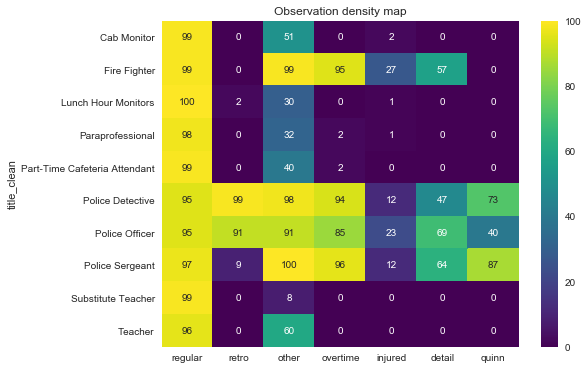

In [15]:
# Observation density map

feature_matrix = top10_titles[['name', 'regular', 'retro', 'other', 'overtime', 'injured', 'detail', 'quinn', 'title_clean']] \
                        .groupby('title_clean') \
                        .apply(lambda x: (x != 0).sum())\
                        .apply(lambda y: (y/y['name']*100).astype(int), axis=1)\
                        .drop(['name', 'title_clean'], axis=1)
                
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(feature_matrix, annot=True, fmt='g', cmap='viridis', ax=ax)
plt.title('Observation density map')
plt.show()

The heatmap above shows the percentage of entries which greater than zero for a given feature, i.e. earnings category. For example, at least 95% of observations for any title have non-zero "regular" entries, but no more than 27% of observations for any title have entries for the "injured" category. 

From this map and the confusion matrix above we can conclude that classification will be very difficult for the following job titles due to low number of feature/observation combinations:

* Cab Monitor
* Lunch Hour Monitors
* Paraprofessional
* Part-Time Cafeteria Attendant
* Substitute Teacher

The "Teacher" title should probably be excluded as well, but this is by far the largest group of observations.

We can also conclude that the "injured" feature is unlikely to have much impact and could be excluded with little loss of accuracy.

Lastly the confusion matrix shows substantial error for "Police Detectives", classifying this title as "Police Officer" in more than one-third of cases. An internet search found that a police detective is considered a police officer who performs detective work. In terms of earnings there is little difference and the two titles should be merged.

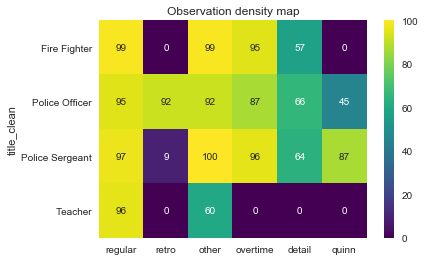

Confusion Matrix:
                   0    1   2     3  count  score
Fire Fighter     423    2   1    33    459  92.16
Police Officer     7  702   1    72    782  89.77
Police Sergeant    3   23  92     4    122  75.41
Teacher            1    0   0  2146   2147  99.95
Accuracy: 0.955 (+/- 0.079)


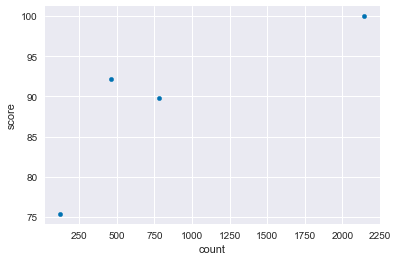

In [16]:
# re-run pipeline with reduced dataset:
new_titles = ['Fire Fighter', 'Police Detective', 'Police Officer', 'Police Sergeant', 'Teacher']

top10_new = top10_titles[['name','regular', 'retro', 'other', 'overtime', 'detail', 'quinn', 'title_clean', 'dept_clean']] \
                    [top10_titles['title_clean'].isin(new_titles)]
    
# merge detectives and police officers    
top10_new['title_clean'].replace({'Police Detective': 'Police Officer'}, inplace=True)

# Observation density map
feature_matrix = top10_new.groupby('title_clean') \
                        .apply(lambda x: (x != 0).sum())\
                        .apply(lambda y: (y/y['name']*100).astype(int), axis=1)\
                        .drop(['name', 'title_clean', 'dept_clean'], axis=1)
sns.heatmap(feature_matrix, annot=True, fmt='g', cmap='viridis')
plt.title('Observation density map')
plt.show()

# define classification data
X = top10_new.drop(['name', 'title_clean', 'dept_clean'], axis=1)
y = top10_new['title_clean']

# split into training and test data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=26)

# fit the pipeline
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

# metrics:
print('Confusion Matrix:')
cm = pd.DataFrame(metrics.confusion_matrix(y_test, pred)).set_index(np.sort(top10_new['title_clean'].unique()))
cm['count'] = cm.sum(axis=1)
cm['score'] = 0
for row in range(4):
    cm.iloc[row, 5] = round(cm.iloc[row, row] / cm.iloc[row, 4] * 100, 2)
print(cm)
cv_scores = cross_val_score(pipeline, X, y, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (cv_scores.mean(), cv_scores.std() * 2))
cm.plot.scatter('count', 'score')
plt.show()


The revised results show that classification accuracy is closely correlated with the number of employees (or observations). The accuracy is 96% before optimization and cross validation.

In [17]:
# hyper-parameter tuning

# param_grid = {'C': [0.1, 1, 10],
#               'gamma': [0.001, 0.01, 0.1]}

# gs = GridSearchCV(svm.SVC(), param_grid, cv=5)
# gs.fit(X_train, y_train)
# print(gs.best_params_)
# print(gs.best_score_)
# cv_scores = cross_val_score(lrc, X, y, cv=5, scoring='roc_auc')
# print('mean cv score:', np.mean(cv_scores), '\n')


In [18]:
# from skopt import BayesSearchCV

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=26)

# # log-uniform: understand as search over p = exp(x) by varying x
# opt = BayesSearchCV(
#     svm.SVC(),
#     {
#         'C': (1e-3, 1e+3, 'log-uniform'),  
#         'gamma': (1e-3, 1e+1, 'log-uniform'),
# #         'degree': (3, 5),  # integer valued parameter
#         'kernel': ['linear', 'rbf'],  # categorical parameter  , 'poly'
#     },
#     n_iter=6
# )

# opt.fit(X_train, y_train)

# print("Parameters: ", opt.best_params_)
# print("val. score: %s" % opt.best_score_)
# print("test score: %s" % opt.score(X_test, y_test))

In [19]:
# Using optimized hyper-parameters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
steps = [('scaler', StandardScaler()), ('clf', svm.SVC(C=1000, kernel='linear', gamma=0.01))]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)
cv_scores = cross_val_score(pipeline, X_test, y_test, cv=5)
print("Accuracy: %0.3f (+/- %0.3f)" % (cv_scores.mean(), cv_scores.std() * 2))

Accuracy: 0.966 (+/- 0.011)


In [20]:

# Create an SelectKBest object to select features with two best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k=3)

# Apply the SelectKBest object to the features and target
# steps = [('scaler', StandardScaler()), (fvalue_selector), ('clf', svm.SVC(C=1000, gamma=0.01))]
pipeline = make_pipeline(StandardScaler(), fvalue_selector, svm.SVC(C=1000, kernel='linear', gamma=0.01))
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)
y_pred = pipeline.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
# cv_scores = cross_val_score(pipeline, X, y, cv=5)
# print("Mean CV score: %0.3f (+/- %0.3f)" % (cv_scores.mean(), cv_scores.std() * 2))


                 precision    recall  f1-score   support

   Fire Fighter       0.98      0.94      0.96       358
 Police Officer       0.98      0.92      0.95       576
Police Sergeant       0.97      0.79      0.87        81
        Teacher       0.96      1.00      0.98      1618

    avg / total       0.97      0.97      0.97      2633



                   0    1   2     3  count  score
Fire Fighter     337    2   0    19    358  94.13
Police Officer     3  528   2    43    576  91.67
Police Sergeant    4   11  64     2     81  79.01
Teacher            1    0   0  1617   1618  99.94
Mean CV score: 0.96 (+/- 0.02)


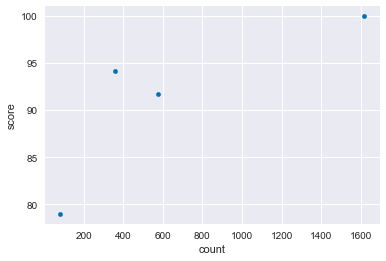

In [21]:
# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)

pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

# metrics:
cm = pd.DataFrame(metrics.confusion_matrix(y_test, pred)).set_index(np.sort(top10_new['title_clean'].unique()))
cm['count'] = cm.sum(axis=1)
cm['score'] = 0
for row in range(4):
    cm.iloc[row, 5] = round(cm.iloc[row, row] / cm.iloc[row, 4] * 100, 2)
print(cm)
cv_scores = cross_val_score(pipeline, X_test, y_test, cv=10)
print("Mean CV score: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
cm.plot.scatter('count', 'score')
plt.show()


In [22]:
clf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=5, random_state=26).fit(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   Fire Fighter       0.99      0.95      0.97       358
 Police Officer       0.98      0.97      0.97       576
Police Sergeant       1.00      0.89      0.94        81
        Teacher       0.98      1.00      0.99      1618

    avg / total       0.98      0.98      0.98      2633



In [27]:
# Random Forest Classifier:
clf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=5, random_state=26).fit(X_train, y_train)
clf.score(X_test, y_test)

y_pred = clf.predict(X_test)

# confusion matrix
print('Confusion Matrix:')
cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)).set_index(np.sort(top10_new['title_clean'].unique()))
cm['count'] = cm.sum(axis=1)
cm['score'] = 0
for row in range(4):
    cm.iloc[row, 5] = round(cm.iloc[row, row] / cm.iloc[row, 4] * 100, 2)
print(cm)
print('-----------')
print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

# cross validation
cv_scores = cross_val_score(pipeline, X_test, y_test, cv=10)
print("Mean CV score: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))


Confusion Matrix:
                   0    1   2     3  count  score
Fire Fighter     340    2   0    16    358  94.97
Police Officer     3  556   0    17    576  96.53
Police Sergeant    1    7  72     1     81  88.89
Teacher            0    4   0  1614   1618  99.75
-----------
Classification Report:
                 precision    recall  f1-score   support

   Fire Fighter       0.99      0.95      0.97       358
 Police Officer       0.98      0.97      0.97       576
Police Sergeant       1.00      0.89      0.94        81
        Teacher       0.98      1.00      0.99      1618

    avg / total       0.98      0.98      0.98      2633

Mean CV score: 0.96 (+/- 0.02)


### 4. Classification by department

In [28]:
# data for classifiers (now including quinn):
top10_d = earnings[(earnings['dept_clean'].isin(departments_top10)) & (earnings['year'] == 2017)]

# remove non-numeric columns as well as "total" and "quinn"
X = top10_d.drop(['name', 'department', 'title', 'quinn', 'total', 'zip', 'year', 'title_clean', 'dept_clean'], axis=1)

# factorize job titles
# y = pd.factorize(top10['title_clean'])[0]
y = top10_d['dept_clean']

# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
X_test.shape[0]

4113

                                0    1    2  3     4  5  6  7   8  9  count  score
Boston Cntr - Youth & Families  0    0    0  0   107  0  0  0   0  0    107   0.00
Boston Fire Department          0  277   26  0    21  0  0  0   2  0    326  84.97
Boston Police Department        0   27  450  0   169  1  0  0   1  0    648  69.44
Boston Public Library           0    1    1  0   104  0  0  0   0  0    106   0.00
Boston Public Schools           0   10   11  0  2587  0  0  0   0  0   2608  99.19
Inspectional Services Dept      0    2   29  0    15  0  0  0   0  0     46   0.00
Parks Department                0    1   19  0    40  0  0  0   5  0     65   0.00
Public Facilities Department    0    1    5  0    25  0  0  9   1  0     41  21.95
Public Works Department         0    3   36  0    20  0  0  0  27  0     86  31.40
Traffic Division                0    0   59  0    16  0  0  0   5  0     80   0.00
Mean CV score: 0.82 (+/- 0.02)


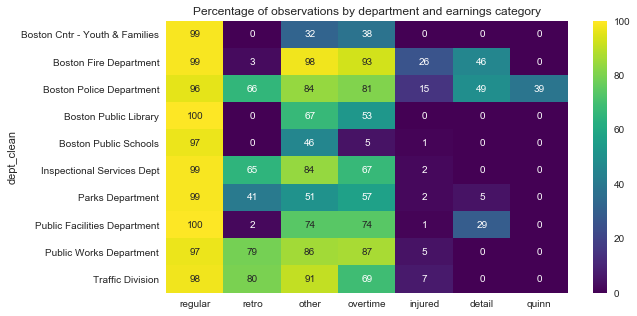

In [29]:
# support vector classifier

steps = [('scaler', StandardScaler()), ('clf', svm.SVC())]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

y_pred = cross_val_predict(pipeline, X_test, y_test, cv=5)

# confusion matrix
cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)).set_index(np.sort(top10_d['dept_clean'].unique()))
cm['count'] = cm.sum(axis=1)
cm['score'] = 0
for row in range(10):
    cm.iloc[row, 11] = round(cm.iloc[row, row] / cm.iloc[row, 10] * 100, 2)
print(cm)

# cross validation
cv_scores = cross_val_score(pipeline, X_test, y_test, cv=10)
print("Mean CV score: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

feature_matrix = top10_d.groupby('dept_clean') \
                        .apply(lambda x: (x != 0).sum())\
                        .apply(lambda y: (y/y['name']*100).astype(int), axis=1)\
                        .drop(['name', 'department', 'title', 'total', 'year', 'zip', 'dept_clean', 'title_clean'], axis=1)

fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(feature_matrix, annot=True, fmt='g', cmap='viridis', ax=ax)
ax.set_title('Percentage of observations by department and earnings category')
plt.show()

The support vector classifier correctly identifies the department 82% of the time. As seen with the *titles* above, the success is highly dependent on the number of supporting observations. Interestingly, most of the smaller departments are misclassified as belonging to the ***Boston Public Schools*** department. The high accuracy of 99.19% for the school department suggests that this is the dominant category due to the overwhelming number of employees. We can remove a few departments to see how things change. 

In [30]:
# reduced data for classifiers:

departments_top10 = set(departments_top10) - set(['Boston Public Library', 'Inspectional Services Dept', 'Parks Department', 'Boston Cntr - Youth & Families', 'Traffic Division'])
top10_d = earnings[(earnings['dept_clean'].isin(departments_top10)) & (earnings['year'] == 2017)]

# remove non-numeric columns as well as "total" and "quinn"
X = top10_d.drop(['name', 'department', 'title', 'quinn', 'total', 'zip', 'year', 'title_clean', 'dept_clean'], axis=1)

# factorize department names
# y = pd.factorize(top10['title_clean'])[0]
y = top10_d['dept_clean']

# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

# label prediction
y_pred = cross_val_predict(pipeline, X_test, y_test, cv=5)

# confusion matrix
cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)).set_index(np.sort(top10_d['dept_clean'].unique()))
cm['count'] = cm.sum(axis=1)
cm['score'] = 0
for row in range(5):
    cm.iloc[row, 6] = round(cm.iloc[row, row] / cm.iloc[row, 5] * 100, 2)
print(cm)

# cross validation
cv_scores = cross_val_score(pipeline, X_test, y_test, cv=10)
print("Mean CV score: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))


                                0    1     2  3   4  count  score
Boston Fire Department        257   30    36  0   2    325  79.08
Boston Police Department       20  450   167  0   2    639  70.42
Boston Public Schools          10    3  2615  0   0   2628  99.51
Public Facilities Department    3    6    34  0   1     44   0.00
Public Works Department         1   31    22  0  24     78  30.77
Mean CV score: 0.90 (+/- 0.03)


In [32]:
# Random Forest Classifier:
clf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=5, random_state=26).fit(X_train, y_train)
clf.score(X_test, y_test)

y_pred = clf.predict(X_test)

# confusion matrix
print('Confusion Matrix:')
cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)).set_index(np.sort(top10_d['dept_clean'].unique()))
cm['count'] = cm.sum(axis=1)
cm['score'] = 0
for row in range(5):
    cm.iloc[row, 6] = round(cm.iloc[row, row] / cm.iloc[row, 5] * 100, 2)
print(cm)
print('-----------')
print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

# cross validation
cv_scores = cross_val_score(pipeline, X_test, y_test, cv=10)
print("Mean CV score: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))


Confusion Matrix:
                                0    1     2  3   4  count  score
Boston Fire Department        283    8    23  0  11    325  87.08
Boston Police Department       22  510    98  0   9    639  79.81
Boston Public Schools           9   10  2608  0   1   2628  99.24
Public Facilities Department    4   10    20  9   1     44  20.45
Public Works Department         2    3     6  0  67     78  85.90
-----------
Classification Report:
                              precision    recall  f1-score   support

      Boston Fire Department       0.88      0.87      0.88       325
    Boston Police Department       0.94      0.80      0.86       639
       Boston Public Schools       0.95      0.99      0.97      2628
Public Facilities Department       1.00      0.20      0.34        44
     Public Works Department       0.75      0.86      0.80        78

                 avg / total       0.94      0.94      0.93      3714

Mean CV score: 0.90 (+/- 0.03)


### Summary

The random forest classifier performs reasonably well for the five selected departments. Primarily due to the small number of observations and features it only makes sense to consider classification on the top 3 departments:

- ***Boston Fire Department***
- ***Boston Police Department***
- ***Boston Public Schools***

Classification by job title is also best performed with a random forest classifier and performs well if the data is limited to the top 4 job titles:

- ***Fire Fighter***
- ***Police Officer***
- ***Police Sergeant***
- ***Teacher***

The need to limit the data is a result of the small number of earnings features, most of which are primarily used for police and fire departments. 

Another way to look at the data is that many departments (or job titles) do not discriminate pay based on the ***regular*** earnings feature alone. 